<a href="https://colab.research.google.com/github/deivisongithub/Series_Temporais/blob/main/series_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mudanças anuais na rotação da Terra

Grupo:
* Deivison Rodrigues Jordão - 20200023728
* Dayane Freitas Felipe Ramos - 20190093910
* Arthur Cesar Cardoso Clemente - 20190175757



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


In [ ]:
df = pd.read_csv('Annual changes in the earths rotation day length sec105 18211970.csv')

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df['date'] = pd.date_range('1821','1971', freq='1Y')
df = df.set_index('date')
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

In [ ]:
df

,x
1821-12-31,-217
1822-12-31,-177
1823-12-31,-166
1824-12-31,-136
1825-12-31,-110
...,...
1966-12-31,231
1967-12-31,244
1968-12-31,239
1969-12-31,263


In [ ]:
len(df['x'])

150

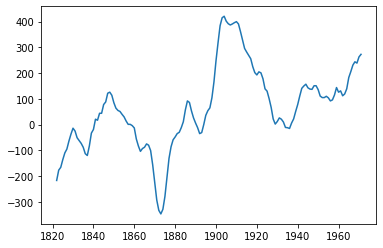

In [ ]:
plt.plot(df['x'])

plt.show()

In [ ]:
def check_stationarity(series):

    result = adfuller(series) 

    print('Estatística ADF: %f' % result[0])

    print('p-valor: %f' % result[1])
    if result[1]<0.05:
        print('A série temporal é estacionária')
    else: 
        print('A série temporal não é estacionária pois p-valor ≥ 0,05')

In [ ]:
check_stationarity(df['x'])

Estatística ADF: -2.033183
p-valor: 0.272215
A série temporal não é estacionária pois p-valor ≥ 0,05




*   Portanto, a série não é estacionária, há uma tendência visível no gráfico. Vamos ver se há uma sazonalidade.



In [ ]:
def series_decomposition(series, method='additive'):
    result = seasonal_decompose(series, model=method)
    result.plot()
    plt.show()

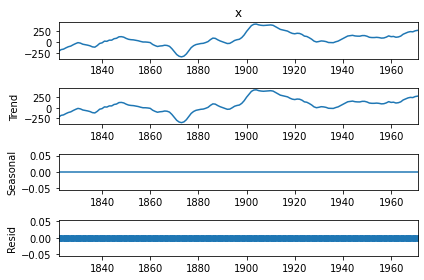

In [ ]:
series_decomposition(df['x'])

* Sem sazonalidade, e uma tendência. Isso exige o modelo ARIMA.

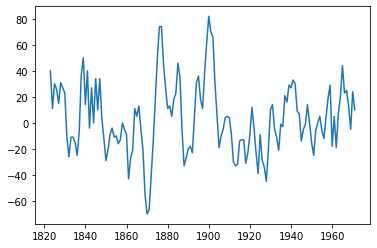

In [ ]:
df_diff = df
plt.plot(df_diff['x'].diff(1))
plt.show()

In [ ]:
check_stationarity(df_diff['x'].diff(1).dropna())

Estatística ADF: -3.835409
p-valor: 0.002565
A série temporal é estacionária


* O parâmetro d é igual a 1. Agora, vamos tentar encontrar os outros parâmetros.

In [ ]:
def plot_acf_pacf_graphs(series):
    fig, ax = plt.subplots(2,1)
    fig = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax[1])
    plt.tight_layout()
    plt.show()

Abaixo está o gráfico de autocorrelação. Quando a autocorrelação diminui muito rápido, pode indicar superdiferença e se a autocorrelação diminui muito lentamente (permanece positiva por mais de 10 defasagens), indica subdiferença.

No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. A região azul indica onde é significativamente diferente de zero. Como é possível ver na imagem, praticamente todos os valores ACF estão dentro do limite da linha tracejada azul. Ou seja, autocorrelação igual a zero, indicando que a série é aleatória

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


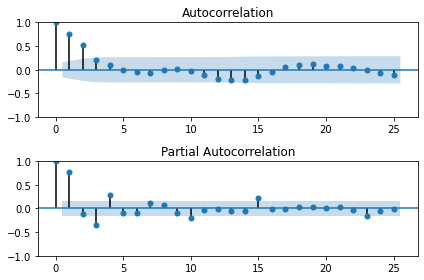

In [ ]:
plot_acf_pacf_graphs(df['x'].diff(1).dropna())

O gráfico ACF lhe dá uma ideia de como correlacionado seu sinal com os atrasos anteriores. Este gráfico ajudará a identificar os componentes da média móvel. Então, analisamos os atrasos de classificação baixa e vemos aqueles que são significativos. e o primeiro é o seu q. Agora, se você tem um componente sazonal, veja os múltiplos do período de sazonalidade,
se você encontrar atrasos significativos, esse é o seu Q.

O gráfico PACF dá a ideia sobre a parte auto-regressiva do modelo. Da mesma forma que o ACF, identificamos p com defasagens de lei e P (se tivermos componente sazonal) é identificado através dos múltiplos do período de sazonalidade.

ACF sugere que precisamos de um componente de média móvel com q = 2 (lag 2 é significativo). Talvez também um componente auto-regressivo com p = 4.

Vamos tentar a combinação desses modelos separadamente. Então vamos estudar 3 modelos:

1. ARIMA(4,1,2)
2. ARIMA(4,1,0)
3. ARIMA(0,1,2)

Esses modelos são comparados:

In [ ]:
def arima_modeling(series, params):
    mod = sm.tsa.arima.ARIMA(series,order=params)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(params,results.aic))
    print(results.summary())
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()

ARIMA(4, 1, 2) - AIC:1254.8485263823786
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  150
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -620.424
Date:                Mon, 10 Oct 2022   AIC                           1254.849
Time:                        03:33:58   BIC                           1275.876
Sample:                    12-31-1821   HQIC                          1263.392
                         - 12-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3924      0.256      1.531      0.126      -0.110       0.895
ar.L2          0.2000      0.166      1.208      0.227      -0.124       0.524
ar.L3       

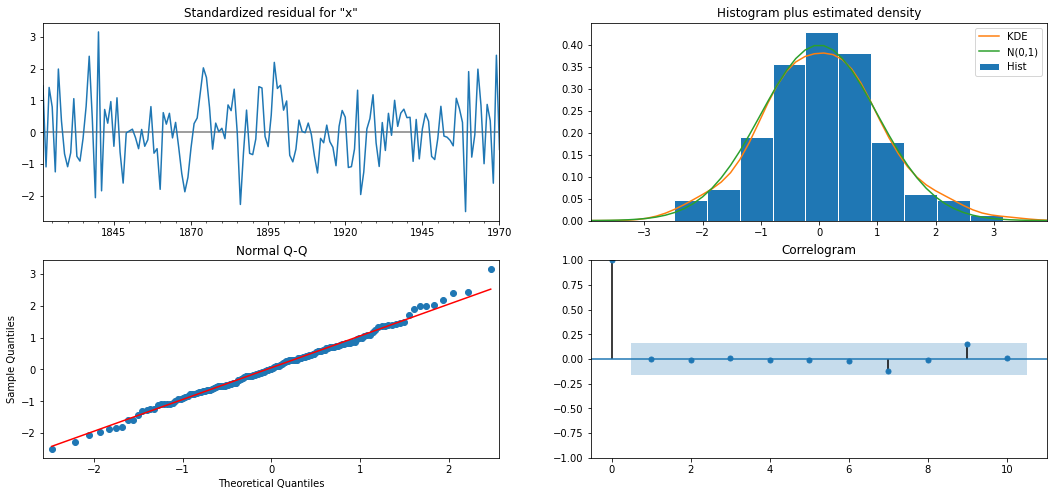

In [ ]:
arima_modeling(df['x'], (4,1,2))

O gráfico de séries temporais dos resíduos padronizados indica principalmente que não há tendência nos resíduos, não há discrepâncias e, em geral, não há variância de variação ao longo do tempo.

O gráfico QQ é um gráfico de probabilidade normal. Não parece tão ruim, então a suposição de resíduos normalmente distribuídos parece boa.


ARIMA(4, 1, 0) - AIC:1256.870339008476
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  150
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -623.435
Date:                Mon, 10 Oct 2022   AIC                           1256.870
Time:                        03:33:58   BIC                           1271.890
Sample:                    12-31-1821   HQIC                          1262.973
                         - 12-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9163      0.071     12.896      0.000       0.777       1.056
ar.L2          0.1211      0.088      1.376      0.169      -0.051       0.294
ar.L3        

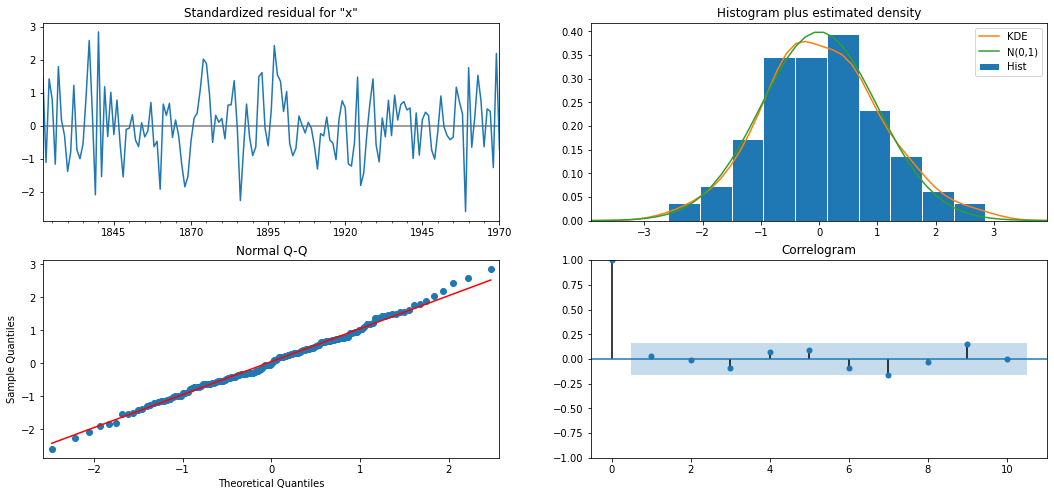

In [ ]:
arima_modeling(df['x'], (4,1,0))

ARIMA(0, 1, 2) - AIC:1261.1932433476773
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  150
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -627.597
Date:                Mon, 10 Oct 2022   AIC                           1261.193
Time:                        03:33:59   BIC                           1270.205
Sample:                    12-31-1821   HQIC                          1264.855
                         - 12-31-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8315      0.052     16.000      0.000       0.730       0.933
ma.L2          0.7026      0.061     11.451      0.000       0.582       0.823
sigma2      

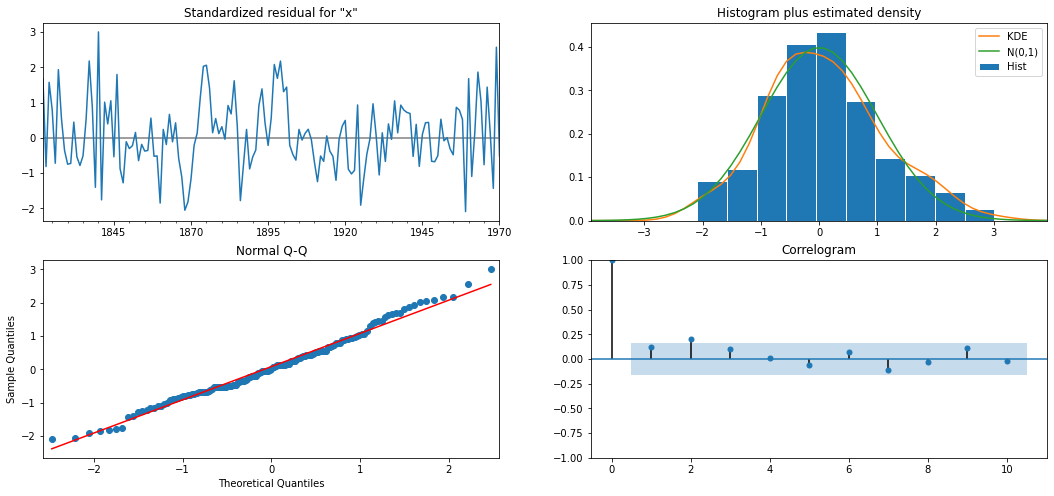

In [ ]:
arima_modeling(df['x'], (0,1,2))

Com base no AIC podemos ver que o melhor modelo é o ARIMA(4,1,2).

Vamos ver o desempenho deles nas previsões.

In [ ]:
def arima_prediction(series, params, start_point):
    model = sm.tsa.arima.ARIMA(series,order=params).fit()
    pred = model.get_prediction(start=start_point, dynamic=False)
    pred_ci = pred.conf_int()
    ax = series.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Quantity')
    plt.legend()
    plt.show()

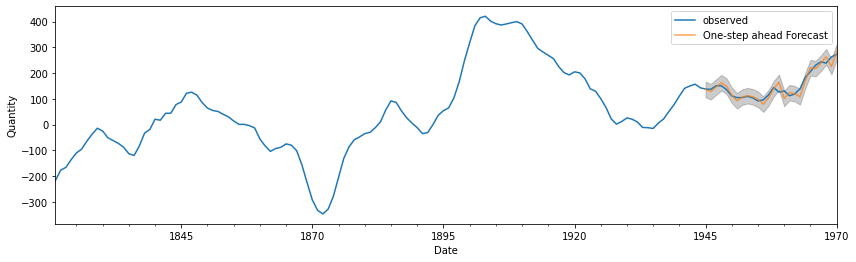

In [ ]:
arima_prediction(df['x'], (4,1,2), start_point=pd.to_datetime('1945-12-31'))

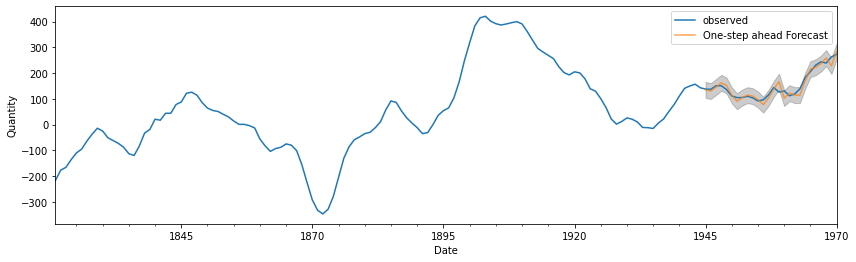

In [ ]:
arima_prediction(df['x'], (4,1,0), start_point=pd.to_datetime('1945-12-31'))

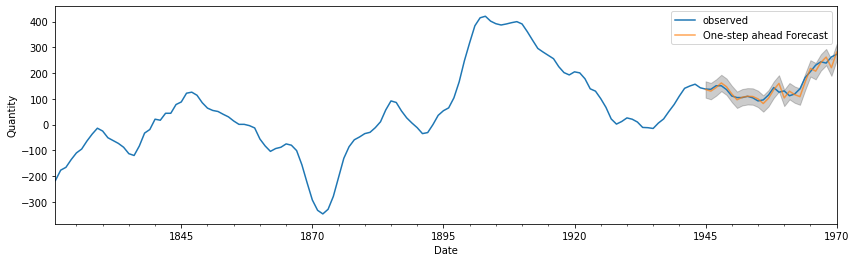

In [ ]:
arima_prediction(df['x'], (0,1,2), start_point=pd.to_datetime('1945-12-31'))

O desempenho deles é bastante semelhante, não podemos decidir apenas com enredos. Esse resultado é bastante suspeito, pois o AIC não varia muito de um modelo para outro. Vamos avançar para validá-los.

In [ ]:
def arima_walk_forward_validation(series, params, test_size):
    n_train = int(len(series) * (1-test_size))
    train, test = series.values[0:n_train], series.values[n_train:len(series)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = sm.tsa.arima.ARIMA(history, order=params)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Teste RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Teste RMSE: 17.260


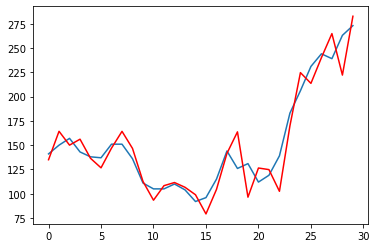

In [ ]:
arima_walk_forward_validation(df['x'], (4,1,2), test_size=0.2)

Teste RMSE: 15.738


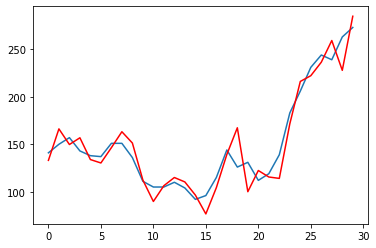

In [ ]:
arima_walk_forward_validation(df['x'], (4,1,0), test_size=0.2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Teste RMSE: 17.181


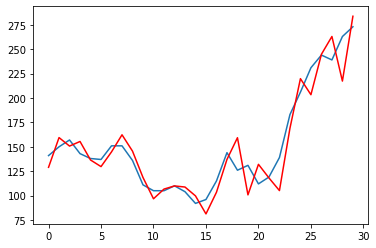

In [ ]:
arima_walk_forward_validation(df['x'], (0,1,2), test_size=0.2)

Surpreendentemente, os resultados da validação walk-forward são melhores para ARIMA(4,1,0).

Vamos prever a evolução desta medida nos próximos 4 anos.

In [ ]:
def arima_walk_forward_forecast(series, params, steps=5):
    history = series.copy()
    predictions = [history.iloc[-1]]
    predictions_ci_min = [history.iloc[-1]]
    predictions_ci_max = [history.iloc[-1]]
    predictions_ci_index = [history.index[-1]]
    for t in range(steps):
        model = sm.tsa.arima.ARIMA(history, order=params)
        model_fit = model.fit()
        predictions.append(model_fit.get_forecast().predicted_mean[0])
        predictions_ci_min.append(model_fit.get_forecast().conf_int().values[0,0])
        predictions_ci_max.append(model_fit.get_forecast().conf_int().values[0,1])
        predictions_ci_index.append(model_fit.get_forecast().conf_int().index.tolist()[0])
        history = history.append(model_fit.get_forecast().predicted_mean)
    plt.figure(figsize=(14, 4))
    plt.plot(predictions_ci_index, predictions, label='Walk-Forward ahead Forecast', alpha=.7, color='red')
    plt.plot(series, label='observed', color='blue')
    plt.fill_between(predictions_ci_index, predictions_ci_min, predictions_ci_max, color='k', alpha=.2)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

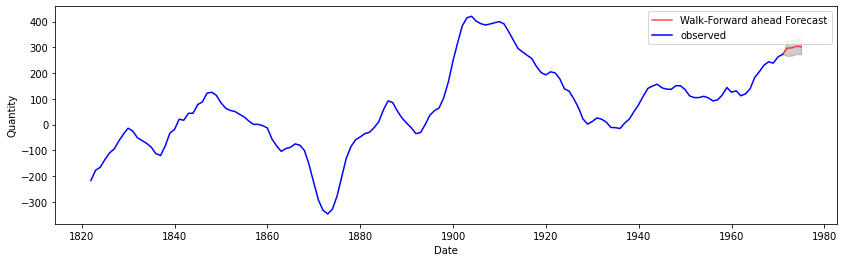

In [ ]:
arima_walk_forward_forecast(df['x'], (4,1,2), steps=4)

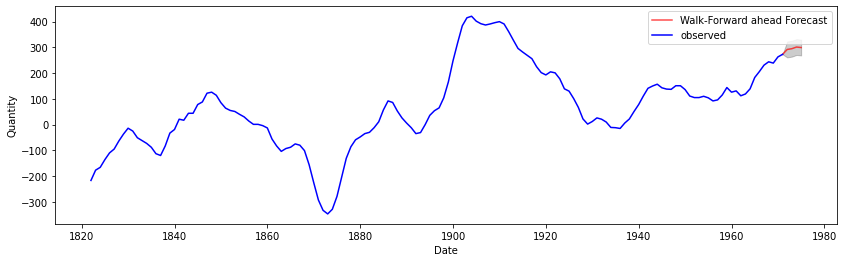

In [ ]:
arima_walk_forward_forecast(df['x'], (4,1,0), steps=4)

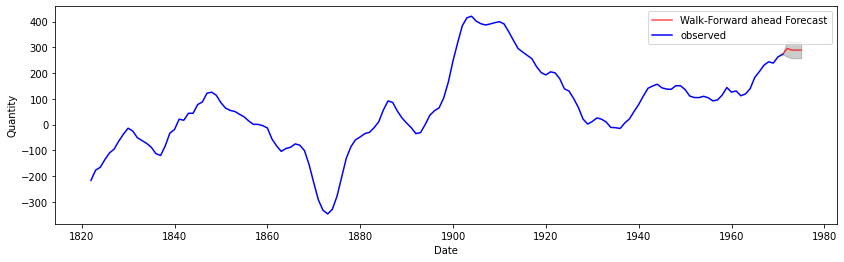

In [ ]:
arima_walk_forward_forecast(df['x'], (0,1,2), steps=4)

Podemos ver que os valores previstos dos dois primeiros modelos são bastante variados, enquanto o terceiro está se estabilizando rapidamente. Isso é explicado pelo componente de média móvel sem o componente AutoRegressivo. O modelo eventualmente irá para o valor médio como uma previsão.

Então, finalmente, poderíamos manter o primeiro ou o segundo modelo.

Claro, podemos ir mais longe e otimizar os parâmetros usando a pesquisa de grade (mas este não é o objetivo deste notebook).

## Auto Arima

In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima.arima import auto_arima

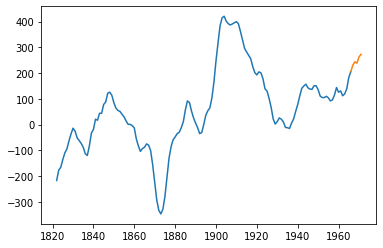

In [ ]:
train = df[:145]
test = df[144:]
plt.plot(train)
plt.plot(test)

In [ ]:
auto_arima_model = auto_arima(train, error_action='warn', trace=True, suppress_warnings=True,
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1206.689, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1367.074, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1244.081, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1297.945, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1366.709, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1207.649, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1243.228, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1207.453, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1207.008, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1244.307, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1208.664, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1216.638, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1208.922, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1205.184, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [ ]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  145
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -597.592
Date:                Mon, 10 Oct 2022   AIC                           1205.184
Time:                        05:17:10   BIC                           1220.033
Sample:                    12-31-1821   HQIC                          1211.218
                         - 12-31-1965                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1036      0.125      0.827      0.408      -0.142       0.349
ar.L2          0.2710      0.113      2.393      0.017       0.049       0.493
ma.L1          0.8812      0.107      8.239      0.000       0.672       1.091
ma.L2          0.6633      0.078      8.515      0.000       0.511       0.816
sigma2       232.0941     27.206      8.531      0.000     178.771     285.417
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.94   Prob(JB):                         0.72
Heteroskedasticity (H):               0.66   Skew:                             0.12
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = pd.DataFrame(auto_arima_model.predict(n_periods = 20),index=test.index)
pred.columns = ['predicted_changes']
pred = pred.dropna()
pred

,predicted_changes
1966-12-31,211.259873
1967-12-31,206.433099
1968-12-31,207.358372
1969-12-31,206.146188
1970-12-31,206.271330


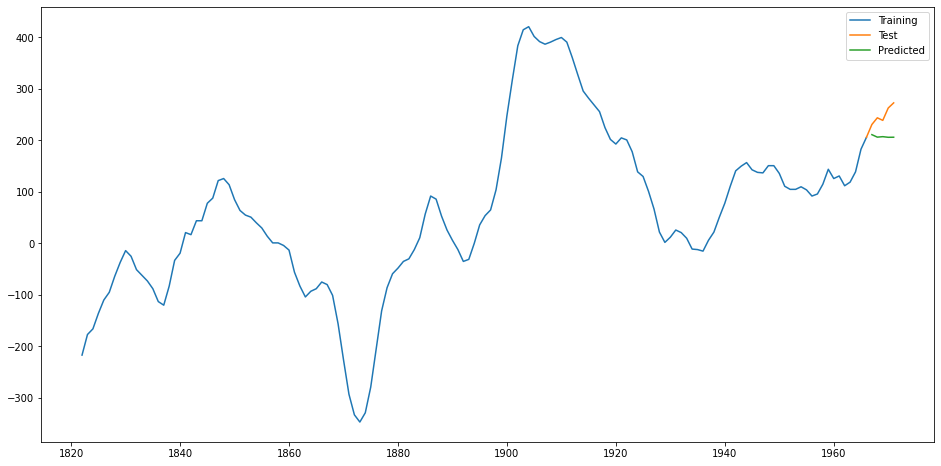

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(pred,label="Predicted")
plt.legend()
plt.show()